In [216]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import matplotlib as plt
import seaborn as sns

### Part 1: Data processing

In [139]:
df = pd.read_csv('./house_sale_data_with_geocodes.csv')

In [140]:
df.head()

,address,zip_code,price,sell_date,sell_type,price_per_sq_m,no_rooms,housing_type,size_in_sq_m,year_of_construction,price_change_in_pct,zip_code_num,long,lat
0,Nykøbingvej 23,4460 Snertinge,150000,05-04-2017,Alm. Salg,1209.0,4.0,Villa,124.0,1934.0,0.0,4460,11.383189,55.714074
1,Bakkekammen 5,4460 Snertinge,1145000,24-03-2017,Alm. Salg,9015.0,3.0,Villa,127.0,1971.0,-4.0,4460,11.381936,55.717096
2,Æblekjærvej 11,4460 Snertinge,700000,15-02-2017,Alm. Salg,6666.0,3.0,Villa,105.0,1946.0,-12.0,4460,11.381427,55.719840
3,Bakkekammen 7,4460 Snertinge,920000,30-01-2017,Alm. Salg,8518.0,4.0,Villa,108.0,1966.0,-3.0,4460,11.382017,55.716914
4,Tværvej 4,4460 Snertinge,300000,01-12-2016,Alm. Salg,3061.0,3.0,Villa,98.0,1964.0,0.0,4460,11.381899,55.710771


We are going to make a classifier which can predict if the house price of a house will increase or decrease og stay the same. We are going to use the following features :  

- zip_code_num
- price
- price_per_sq_m
- no_rooms
- housing_type
- size_in_sq_m
- year_of_construction
- long
- lat

In [141]:
df['housing_type'].unique()

array(['Villa', 'Stuehus', 'Rækkehus', 'Lejlighed', 'Døgninstitution',
       'Sommerhus', 'Detailhandel', 'Undervisning o.l.', 'Anden beboelse',
       'Engroshandel', 'Ukendt', 'BygningTilLager', 'Servicevirksomhed',
       'Erhverv', 'Fritid', 'Kolonihavehus', 'Industri o.l.',
       'Dobbelthus', 'BygningTilHandel', 'Kollegium', 'Biograf o.l.',
       'BygningTilKontor', 'Ferie, andet', 'Anden handel/transport',
       'Landbrug o.l.', 'Idrætsudøvelse', 'Daginstitution', 'Landbrug',
       'Hospital', 'AndenBygningTilKontorHandelLager',
       'Anden Institution', 'Museum o.l.', 'Transport, garage',
       'Tankstation', 'Pengeinstitut o.l.', 'Off. Administration'],
      dtype=object)

We change the housing_type to numbers and save it in a new column called housing_type_bin

In [142]:
le = LabelEncoder()
df['housing_type_bin'] = le.fit_transform(df['housing_type'])

In [143]:
df.head()

,address,zip_code,price,sell_date,sell_type,price_per_sq_m,no_rooms,housing_type,size_in_sq_m,year_of_construction,price_change_in_pct,zip_code_num,long,lat,housing_type_bin
0,Nykøbingvej 23,4460 Snertinge,150000,05-04-2017,Alm. Salg,1209.0,4.0,Villa,124.0,1934.0,0.0,4460,11.383189,55.714074,35
1,Bakkekammen 5,4460 Snertinge,1145000,24-03-2017,Alm. Salg,9015.0,3.0,Villa,127.0,1971.0,-4.0,4460,11.381936,55.717096,35
2,Æblekjærvej 11,4460 Snertinge,700000,15-02-2017,Alm. Salg,6666.0,3.0,Villa,105.0,1946.0,-12.0,4460,11.381427,55.719840,35
3,Bakkekammen 7,4460 Snertinge,920000,30-01-2017,Alm. Salg,8518.0,4.0,Villa,108.0,1966.0,-3.0,4460,11.382017,55.716914,35
4,Tværvej 4,4460 Snertinge,300000,01-12-2016,Alm. Salg,3061.0,3.0,Villa,98.0,1964.0,0.0,4460,11.381899,55.710771,35


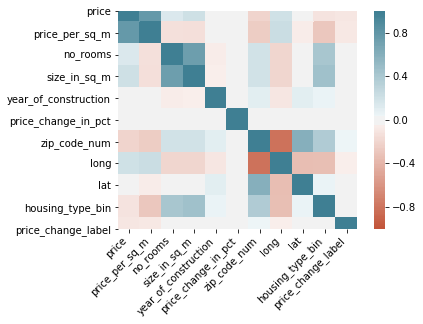

In [217]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Part 2: ML model selection and construction

Next step is to generate labels for the data. We have 3 labels : 

- house price will increase = 2
- house price stay the same = 1
- house price will decrease = 0

Let's generate the labels.

In [144]:
def price_change_label(price_change):
    if price_change > 0.0:
        return 2
    elif price_change < 0.0:
        return 0
    else: 
        return 1

In [145]:
df['price_change_label'] = df.apply(lambda x : price_change_label(x['price_change_in_pct']),axis=1)

Lets see if the dataset is balanced.

In [179]:
count_class_1 , count_class_0 , count_class_2 = df.price_change_label.value_counts()
print(count_class_1,count_class_0,count_class_2)

922902 342021 16915


We can see that the dataset is very unbalanced. so we need to balance it

In [180]:
#Lets make a mask for all of the labels.
df_class_0 = df[df['price_change_label'] == 0]
df_class_1 = df[df['price_change_label'] == 1]
df_class_2 = df[df['price_change_label'] == 2]

In [181]:
# now we take 16915 random values from price_change_label where label is 0 and 1.
df_class_0 = df_class_0.sample(count_class_2)
df_class_1 = df_class_1.sample(count_class_2)

df_class_0_50 = df_class_0.tail(50)
df_class_0 = df_class_0[:16865]

df_class_1_50 = df_class_1.tail(50)
df_class_1 = df_class_1[:16865]

df_class_2_50 = df_class_2.tail(50)
df_class_2 = df_class_2[:16865]

# combine all of the new classes to one dataFrame
df_balanced = pd.concat([df_class_0, df_class_1, df_class_2], axis=0)
df_val_data = pd.concat([df_class_0_50, df_class_1_50, df_class_2_50], axis=0)

In [186]:
df_val_data.shape

(150, 16)

Below we can see that we have one balanced dataFrame

In [185]:
df_balanced.price_change_label.value_counts()

2    16865
1    16865
0    16865
Name: price_change_label, dtype: int64

Now we can make our feature set

In [187]:
X = df_balanced[['zip_code_num','price','price_per_sq_m','no_rooms','housing_type_bin','size_in_sq_m','year_of_construction',
      'long','lat']]
y = df_balanced.price_change_label

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=True)

In [152]:
model = KNeighborsClassifier(3)
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [153]:
y_pred = model.predict(X_test)

Let calculate the acuracy score.

In [154]:
accuracy_score(y_test,y_pred)

0.5374048819053266

In [155]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [156]:
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.5465955133906513

In [157]:
metrics.confusion_matrix(y_test,y_pred)

array([[1248, 1182, 1036],
       [ 657, 2155,  502],
       [ 696,  515, 2128]])

Lets calculate the precesion and recall

In [158]:
metrics.recall_score(y_test,y_pred, average='macro')

0.5492191270220175

In [159]:
metrics.precision_score(y_test,y_pred,average='macro')

0.5399114227867665

### Part 4: Report your findings (BI)

In [168]:
import folium
from IPython.display import IFrame

In [189]:
df_val_data.shape

(150, 16)

In [190]:
price_change_label = df_val_data.price_change_label

In [191]:
price_change_label.head()

1212234    0
1065195    0
523357     0
337245     0
611112     0
Name: price_change_label, dtype: int64

In [192]:
df_val_data = df_val_data.drop(['address','zip_code','sell_date','sell_type','price_change_in_pct',
                                'housing_type','price_change_label'],axis=1)

In [193]:
df_val_data['price_change_pred_label'] = df_val_data.apply(lambda row : model.predict(np.array(row).reshape(1, -1))[0] ,axis=1)


In [194]:
df_predicted = pd.concat([price_change_label,df_val_data],axis=1)

In [195]:
price_change_label.head()

1212234    0
1065195    0
523357     0
337245     0
611112     0
Name: price_change_label, dtype: int64

In [197]:
df_predicted.head()
df_predicted.shape

(150, 11)

In [207]:
my_map = folium.Map(location=[55.88207495748612, 10.636574309440173], zoom_start=6)
for label,pred,lat,long in zip(df_predicted.price_change_label,df_predicted.price_change_pred_label,df_predicted.lat,df_predicted.long):
    color = '#00FF00' if label==pred else '#FF0000'
    folium.CircleMarker(location=[lat, long], radius=2,fill_color='#00FF00',line_color='#00FF00',color=color).add_to(my_map)
my_map.save('./large_flat_trades.html') 

In [208]:
IFrame(src='./large_flat_trades.html', width=700, height=600)